SDBMS Battery Simulation

Initiating PyBamm

In [40]:
import pybamm
from pybamm import BaseModel
from pprint import pprint

Choose Battery Chemical & Model

In [41]:
## [1] Doyle Fuller newman [2] Single Particle Model (SPM) [3] Single Particle Model with Electrolyte (SPMe)
availableModel = ["DFN","SPM", "SPME"]
selectedModel = availableModel[0]
model : BaseModel

match selectedModel:
    case "DFN":
        model : BaseModel = pybamm.lithium_ion.DFN()
    case "SPM":
        model : BaseModel = pybamm.lithium_ion.SPM()
    case "SPME":
        model : BaseModel = pybamm.lithium_ion.SPMe()
        


Print available Parameter

In [42]:
availableModelVariable = model.variable_names()
pprint(availableModelVariable)

['Time [s]',
 'Time [min]',
 'Time [h]',
 'x [m]',
 'x_n [m]',
 'x_s [m]',
 'x_p [m]',
 'r_n [m]',
 'r_p [m]',
 'Current variable [A]',
 'Total current density [A.m-2]',
 'Current [A]',
 'C-rate',
 'Discharge capacity [A.h]',
 'Throughput capacity [A.h]',
 'Discharge energy [W.h]',
 'Throughput energy [W.h]',
 'Porosity',
 'Negative electrode porosity',
 'X-averaged negative electrode porosity',
 'Separator porosity',
 'X-averaged separator porosity',
 'Positive electrode porosity',
 'X-averaged positive electrode porosity',
 'Porosity change',
 'Negative electrode porosity change [s-1]',
 'X-averaged negative electrode porosity change [s-1]',
 'Separator porosity change [s-1]',
 'X-averaged separator porosity change [s-1]',
 'Positive electrode porosity change [s-1]',
 'X-averaged positive electrode porosity change [s-1]',
 'Negative electrode interface utilisation variable',
 'X-averaged negative electrode interface utilisation variable',
 'Negative electrode interface utilisation',


In [43]:
sim = pybamm.Simulation(model)
startDuration = 0
endDuration = 3600 #in second
sim.solve([startDuration, endDuration])

Visualize

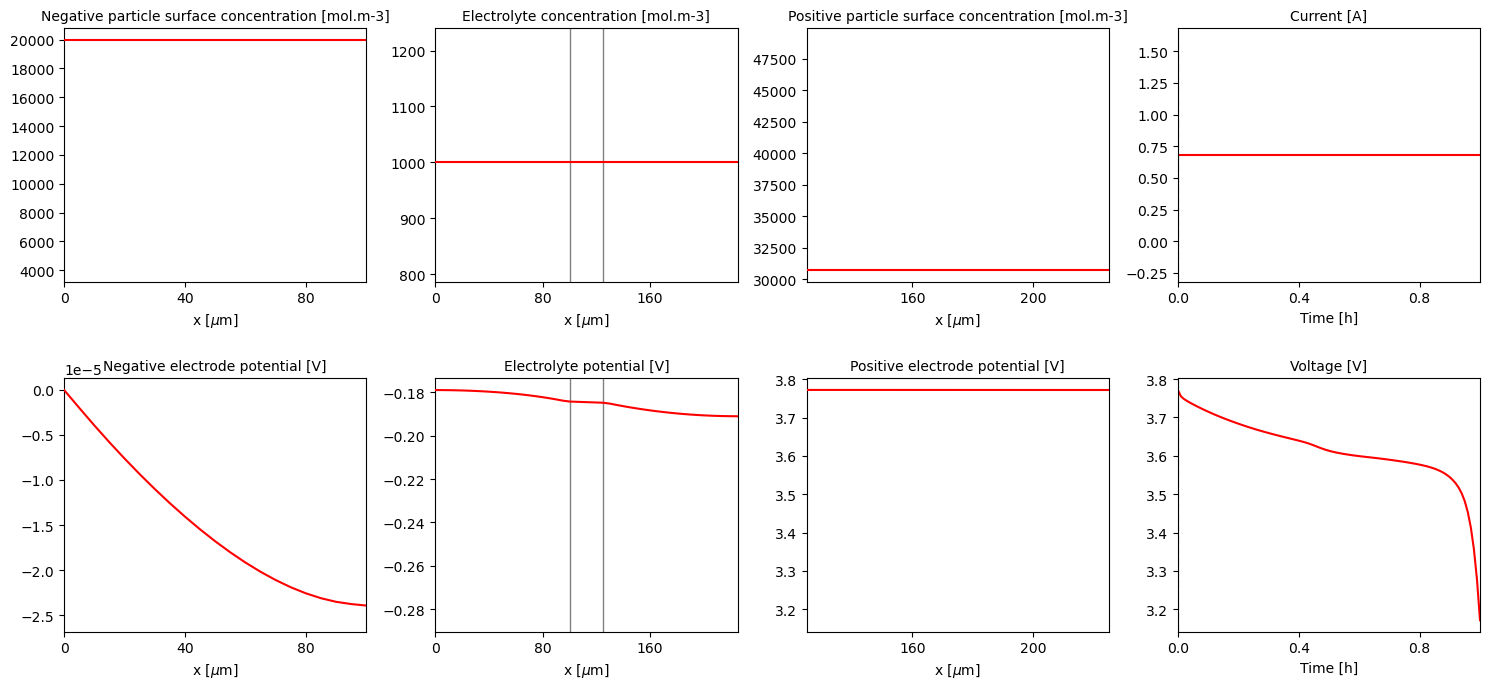

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [44]:
pybamm.dynamic_plot(sim)

Export Plot to HTML (for slider feature)

Custom Plot with Selected Model Result Parameter

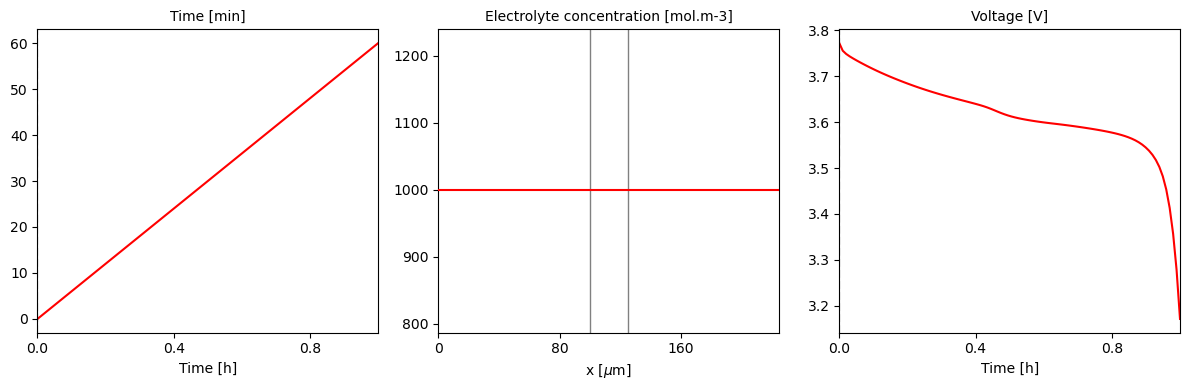

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [45]:
output_variables = ["Time [min]", "Electrolyte concentration [mol.m-3]", "Voltage [V]"]
sim.plot(output_variables=output_variables)

Plot voltage component

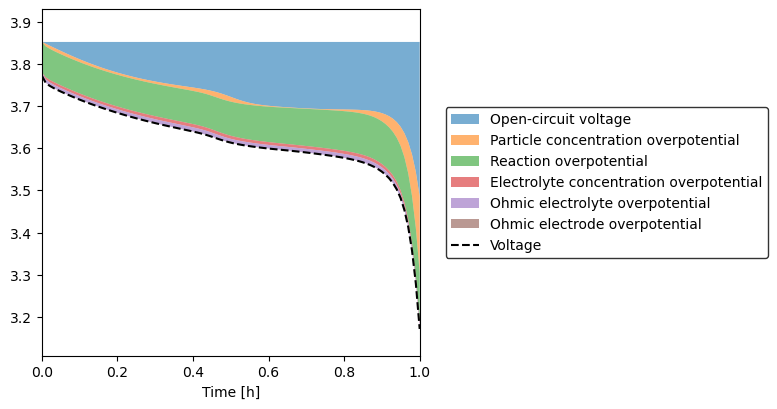

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [46]:
sim.plot_voltage_components()
